Transaction level return prediction: Predict IsReturn for each invoice

Goal in Real Life Application: Proactively suggest alternatives so recall is more important since it's ok to suggest alternatives to more people but you do want to capture those that will most likely return and suggest alternatives 

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
import joblib
from joblib import load
from sklearn.utils import resample

from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, make_scorer, recall_score, confusion_matrix, precision_recall_curve
from imblearn.over_sampling import SMOTE #install imbalanced-learn
import shap
import optuna


In [82]:
df = pd.read_csv('online_retail_cleaned.csv')
df.IsReturn.value_counts()

IsReturn
0    789533
1     16087
Name: count, dtype: int64

In [83]:
def cyclical_encode(df, col_name, period):
    df[col_name + '_sin'] = np.sin(2 * np.pi * df[col_name] / period)
    df[col_name + '_cos'] = np.cos(2 * np.pi * df[col_name] / period)
    return df

# Assuming your DataFrame is 'df' and the month column is 'InvoiceMonth'
df = cyclical_encode(df, 'InvoiceMonth', 12)
df = df.drop('InvoiceMonth', axis=1) # Drop the original InvoiceMonth column

# Assuming your DataFrame is 'df' and the month column is 'InvoiceHour'
df = cyclical_encode(df, 'InvoiceHour', 24)
df = df.drop('InvoiceHour', axis=1) 

In [84]:
# Define target variable
y = df['IsReturn']

# Drop columns that should not be used as features
X = df.drop(columns=['Customer ID','IsReturn', 'Invoice', 'InvoiceDate', 'StockCode','Description',"Country"]) 

In [85]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,  # Ensures class ratio consistency
    random_state=42
)

In [86]:
# weight ratio between the majority class (non-returns) and the minority class (returns) in the training data.
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

scale_pos_weight: 49.08


The scale_pos_weight parameter tells XGBoost to penalize the majority class less and the minority class more, so the model takes returns (IsReturn == 1) more seriously.

Each return is treated as 49 times more important than a non-return.

In [87]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [88]:
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

              precision    recall  f1-score   support

           0       1.00      0.70      0.82    157907
           1       0.05      0.86      0.10      3217

    accuracy                           0.70    161124
   macro avg       0.52      0.78      0.46    161124
weighted avg       0.98      0.70      0.80    161124

AUC-ROC: 0.8711350982908084
AUC-PR: 0.22463149723154444


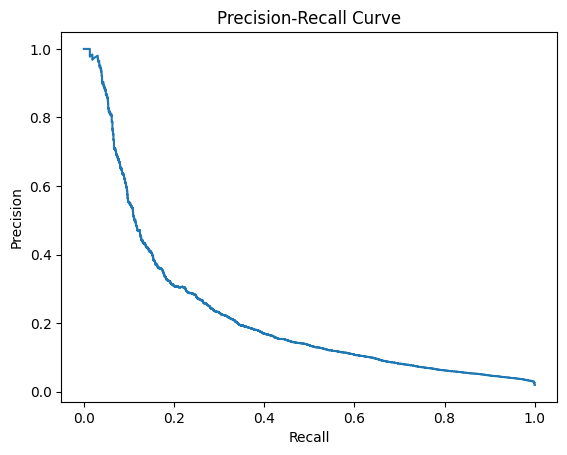

In [89]:
print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba)}")
print("AUC-PR:", average_precision_score(y_test, y_pred_proba))

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

- Recall: Catching 86% of the actual returns
- Precision: Only 5% of the predictions labeled as “return” are actually returns - many false positives 
- F1: Balance between precision and recall is low - but that’s okay because your goal favors recall
- AUC-ROC: Your model ranks returnable transactions well above non-returnables — strong general modeling ability
- AUC-PR: Precision is low, especially when trying to keep recall high — expected when the positive class is super rare (~2%) but doing ~11× better than random, which is solid.

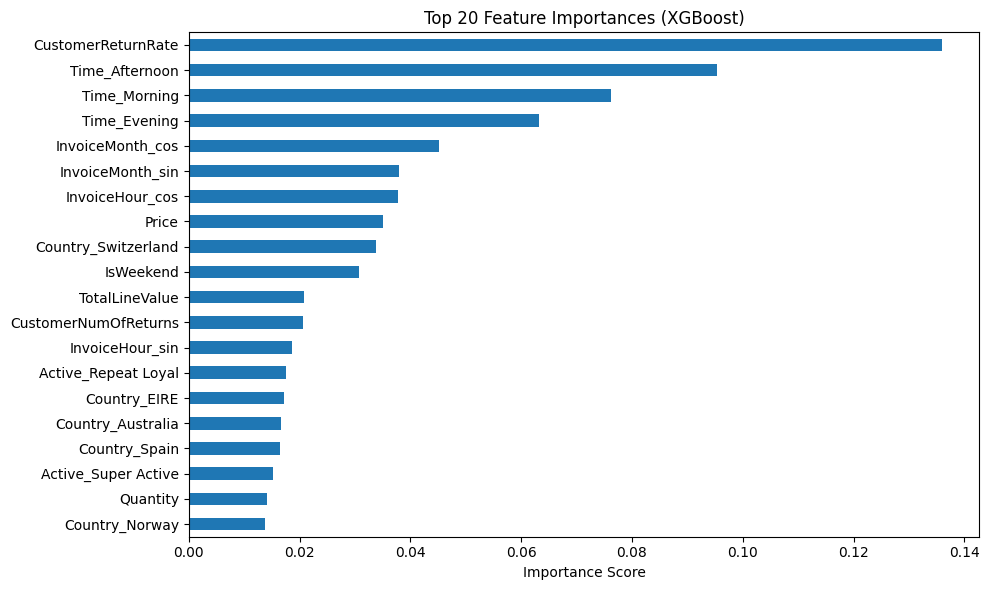

In [90]:
# Get feature importances (based on gain by default)
importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)

# Plot top features
importances.sort_values(ascending=False).head(20).plot(kind='barh', figsize=(10, 6))
plt.title("Top 20 Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [91]:
# Save the model
joblib.dump(xgb_model, "xgb_1.pkl")
# Load it later
#loaded_model = joblib.load("xgb_1.pkl")

['xgb_1.pkl']

Don't use SMOTE only scale_pos_weight

In [92]:
def execute_model(xgb_model, id, scale_pos_weight):
    xgb_model = XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        eval_metric='logloss',
        random_state=42
    )

    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)
    y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred))
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba)}")
    print("AUC-PR:", average_precision_score(y_test, y_pred_proba))

    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.show()

    # Save the model
    joblib.dump(xgb_model, f"xgb_{id}.pkl")
    
    return xgb_model, y_pred, y_pred_proba

              precision    recall  f1-score   support

           0       0.99      0.81      0.89    157907
           1       0.08      0.79      0.14      3217

    accuracy                           0.81    161124
   macro avg       0.54      0.80      0.52    161124
weighted avg       0.98      0.81      0.88    161124

AUC-ROC: 0.8908735415436045
AUC-PR: 0.24261133562512321


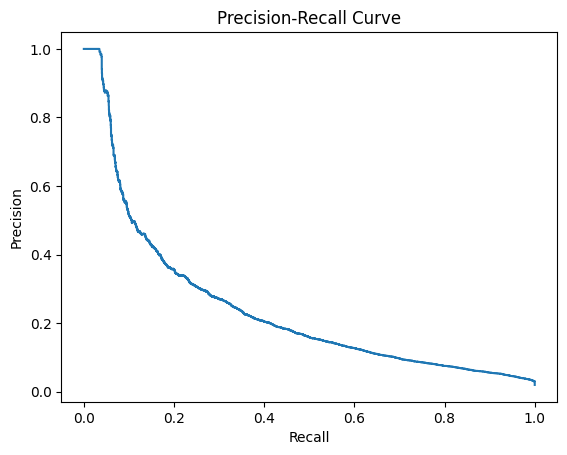

In [93]:
xgb_model_2, y_pred, y_pred_proba = execute_model(xgb_model,2, scale_pos_weight)

In [94]:
# Top 5% Precision
def precision_at_k(y_test, y_pred_custom, k_percent=0.05):
    df_preds = pd.DataFrame({
        'proba': y_pred_custom,         # predicted probabilities for class 1
        'actual': y_test               # true labels (0 or 1)
    })

    # Sort by predicted probability descending (most return-like first)
    df_preds = df_preds.sort_values(by='proba', ascending=False).reset_index(drop=True)

    # Define Top-K% (e.g., top 5%)
    K = int(len(df_preds) * k_percent)

    # Slice top K rows
    top_k = df_preds.iloc[:K]

    # Calculate Top-K Precision
    precision_at_k = top_k['actual'].sum() / K
    print(f"Top-{k_percent*100:.0f}% Precision: {precision_at_k:.4f}")
    return df_preds

Top-5% Precision: 0.1816


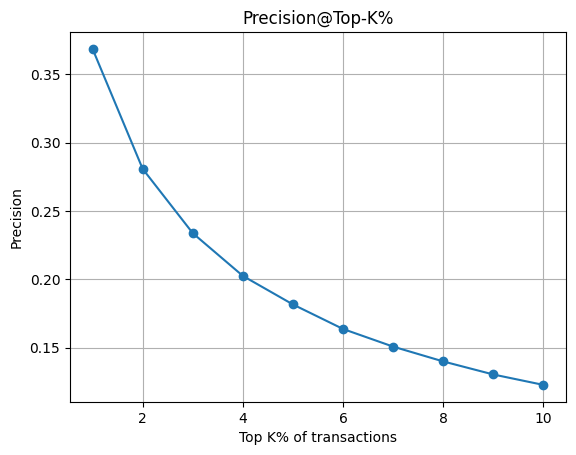

In [95]:
df_preds = precision_at_k(y_test, y_pred_proba, k_percent=0.05)

ks = np.arange(0.01, 0.11, 0.01)  # from 1% to 10%
precision_scores = []

for k in ks:
    K = int(len(df_preds) * k)
    top_k = df_preds.iloc[:K]
    precision = top_k['actual'].sum() / K
    precision_scores.append(precision)

plt.plot(ks * 100, precision_scores, marker='o')
plt.title("Precision@Top-K%")
plt.xlabel("Top K% of transactions")
plt.ylabel("Precision")
plt.grid(True)
plt.show()

Among the top 5% most return-like transactions, 18% were actual returns, which is 9x better than your base return rate (~2%).

Add a threshold for probability predictions.

In [96]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)  # Avoid divide-by-zero

# Find the threshold that maximizes F1
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best threshold: {best_threshold:.3f}")
print(f"Precision: {precision[best_idx]:.3f}, Recall: {recall[best_idx]:.3f}, F1: {f1_scores[best_idx]:.3f}")

Best threshold: 0.874
Precision: 0.265, Recall: 0.315, F1: 0.287


In [97]:
y_pred_custom = (y_pred_proba > best_threshold).astype(int)

In [98]:
print(classification_report(y_test, y_pred_custom))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba)}")
print("AUC-PR:", average_precision_score(y_test, y_pred_proba))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98    157907
           1       0.26      0.31      0.29      3217

    accuracy                           0.97    161124
   macro avg       0.63      0.65      0.64    161124
weighted avg       0.97      0.97      0.97    161124

AUC-ROC: 0.8908735415436045
AUC-PR: 0.24261133562512321


In [99]:
df_preds = precision_at_k(y_test, y_pred_custom, k_percent=0.05)

Top-5% Precision: 0.1329


F1 and precision are the highest of the other iterations. However, recall is significantly lower. 

Try a lower threshold like 0.40 for higher recall. Default is 0.50.

In [100]:
threshold = 0.4
y_pred_custom_50 = (y_pred_proba > threshold).astype(int)

def metric_result(y_pred_custom):
    print(classification_report(y_test, y_pred_custom))
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba)}")
    print("AUC-PR:", average_precision_score(y_test, y_pred_proba))

metric_result(y_pred_custom_50)

              precision    recall  f1-score   support

           0       1.00      0.74      0.85    157907
           1       0.06      0.86      0.12      3217

    accuracy                           0.74    161124
   macro avg       0.53      0.80      0.48    161124
weighted avg       0.98      0.74      0.84    161124

AUC-ROC: 0.8908735415436045
AUC-PR: 0.24261133562512321


In [101]:
df_preds = precision_at_k(y_test, y_pred_custom_50, k_percent=0.05)

Top-5% Precision: 0.0616


Model without scale_pos_weight for the imbalance.

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    157907
           1       0.00      0.00      0.00      3217

    accuracy                           0.98    161124
   macro avg       0.49      0.50      0.49    161124
weighted avg       0.96      0.98      0.97    161124

AUC-ROC: 0.5
AUC-PR: 0.01996598892778233


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

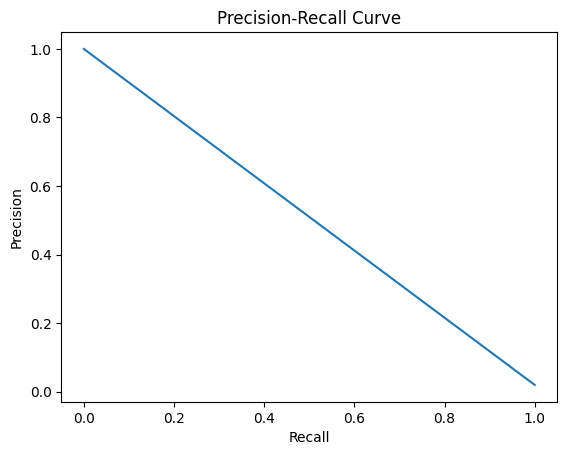

In [102]:
xgb_model_3, y_pred, y_pred_proba = execute_model(xgb_model,3, 0)

With no scale_pos_weight, the model is basically guessing randomly.

Try with just SMOTE for helping the imbalance.

              precision    recall  f1-score   support

           0       0.99      0.98      0.98    157907
           1       0.24      0.29      0.26      3217

    accuracy                           0.97    161124
   macro avg       0.61      0.64      0.62    161124
weighted avg       0.97      0.97      0.97    161124

AUC-ROC: 0.876464879298374
AUC-PR: 0.23386136973973548


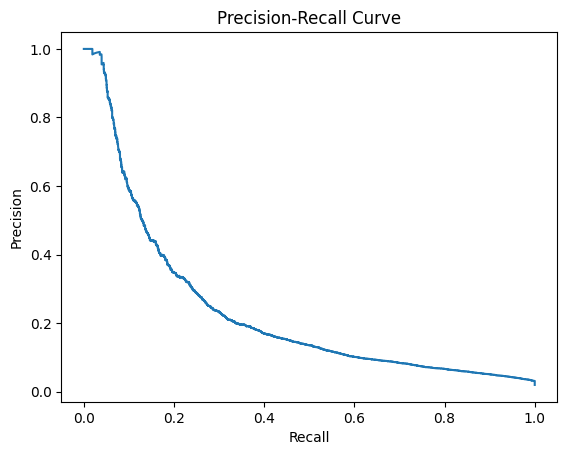

['xgb_4.pkl']

In [103]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

xgb_model = XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_smote, y_train_smote)

y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba)}")
print("AUC-PR:", average_precision_score(y_test, y_pred_proba))

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# Save the model
joblib.dump(xgb_model, "xgb_4.pkl")


#### Feature Importance using Model 2

Model 2 gives better top-K precision, which reflects stronger signal in its features -- understand what drives confident return predictions

In [104]:
model_2 = joblib.load("xgb_2.pkl")

# Initialize the TreeExplainer
explainer = shap.Explainer(model_2)

# Compute SHAP values
shap_values = explainer(X_train)

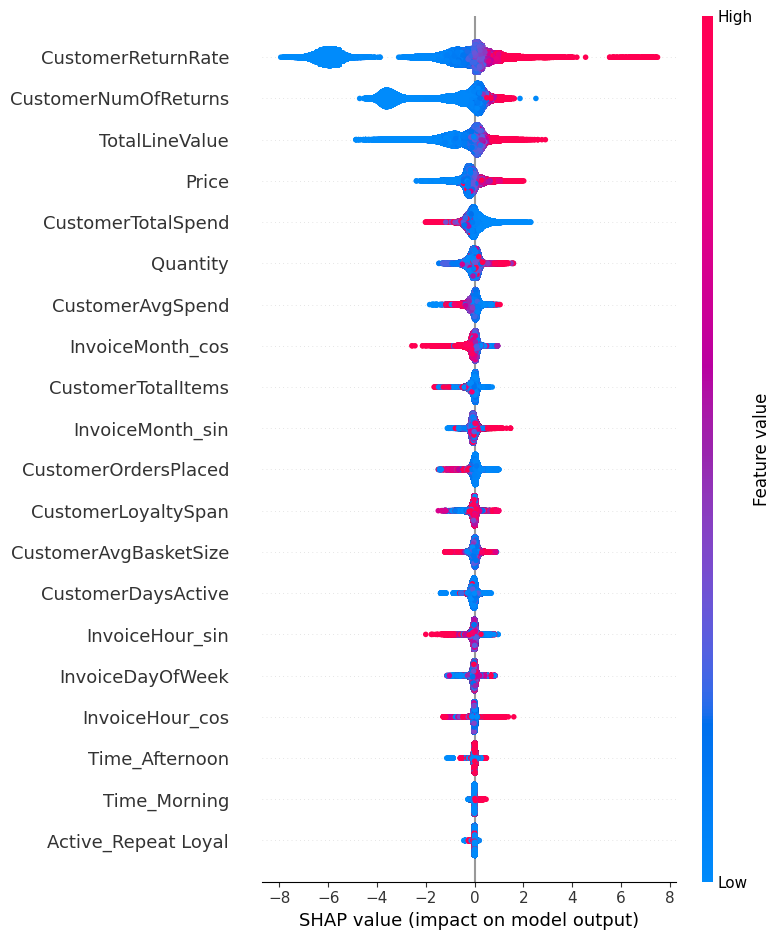

In [105]:
# Summary plot - shows top features across the entire dataset
shap.summary_plot(shap_values, X_train)

A SHAP value shows how much a feature pushes a prediction higher or lower (toward predicting a return or not).
- Values to the right (positive) increase the model’s predicted probability of a return.
- Values to the left (negative) lower the probability of a return.

CustomerReturnRate is the most important feature.
- high values = strongly increase return prediction.

CustomerNumOfReturns
- high values = high return prediction
- past returners are more likely to return again.

TotalLineValue & Price
- higher priced items = higher chance of return

CustomerTotalSpend
- lower total spend = higher return prediction
- higher-value customers are less likely to return

InvoiceMonth
- some months are associated with higher return likelihood

CustomerLoyaltySpan / OrdersPlaced / DaysActive
- Longer relationship = less likely to return

Return rates are lower toward the end of the year (Nov–Dec), then spike back in Jan

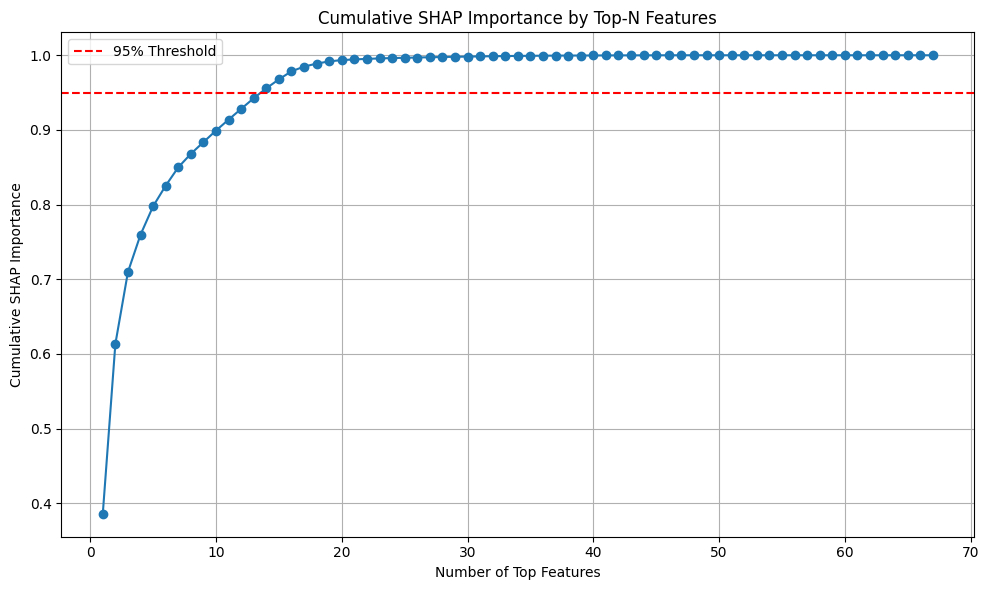

In [106]:
# After computing SHAP values
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
sorted_shap = np.sort(mean_abs_shap)[::-1]
cumulative = np.cumsum(sorted_shap) / np.sum(sorted_shap)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(cumulative)+1), cumulative, marker='o')
plt.axhline(y=0.95, color='red', linestyle='--', label='95% Threshold')
plt.title("Cumulative SHAP Importance by Top-N Features")
plt.xlabel("Number of Top Features")
plt.ylabel("Cumulative SHAP Importance")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [107]:
# Find the cutoff where 95% of SHAP importance is reached
num_features = np.argmax(cumulative >= 0.95) + 1
print(f"Top {num_features} features capture 95% of SHAP importance")

Top 14 features capture 95% of SHAP importance


14 features out of 72 

In [76]:
def shap_reduce(id, num_features):
    shap_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'MeanAbsSHAP': mean_abs_shap
    }).sort_values(by='MeanAbsSHAP', ascending=False)

    # Get top features
    top_features = shap_importance.head(num_features)['Feature'].tolist()
    print(top_features)

    # Filter training and test sets to top SHAP features
    X_train_reduced = X_train[top_features]
    X_test_reduced = X_test[top_features]

    # Retrain
    xgb_reduced = XGBClassifier(scale_pos_weight=scale_pos_weight,
                                use_label_encoder=False,
                                eval_metric='logloss',
                                random_state=42)
    xgb_reduced.fit(X_train_reduced, y_train)

    y_pred = xgb_reduced.predict(X_test_reduced)
    y_pred_proba = xgb_reduced.predict_proba(X_test_reduced)[:, 1]

    print(classification_report(y_test, y_pred))
    print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))
    print("AUC-PR:", average_precision_score(y_test, y_pred_proba))

    df_preds = precision_at_k(y_test, y_pred, k_percent=0.05)
    
    joblib.dump((xgb_reduced, top_features), f"xgb_{id}.pkl")

In [110]:
shap_reduce(5, 14)

['CustomerReturnRate', 'CustomerNumOfReturns', 'TotalLineValue', 'Price', 'CustomerTotalSpend', 'Quantity', 'CustomerAvgSpend', 'InvoiceMonth_cos', 'CustomerTotalItems', 'InvoiceMonth_sin', 'CustomerOrdersPlaced', 'CustomerLoyaltySpan', 'CustomerAvgBasketSize', 'CustomerDaysActive']


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [00:56:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.99      0.80      0.89    157907
           1       0.07      0.79      0.14      3217

    accuracy                           0.80    161124
   macro avg       0.53      0.80      0.51    161124
weighted avg       0.98      0.80      0.87    161124

AUC-ROC: 0.8874514714524512
AUC-PR: 0.23608489817670353
Top-5% Precision: 0.0740


In [108]:
# Find the cutoff where 98% of SHAP importance is reached
num_features = np.argmax(cumulative >= 0.98) + 1
print(f"Top {num_features} features capture 98% of SHAP importance")

Top 17 features capture 98% of SHAP importance


In [109]:
shap_reduce(6, 17)

['CustomerReturnRate', 'CustomerNumOfReturns', 'TotalLineValue', 'Price', 'CustomerTotalSpend', 'Quantity', 'CustomerAvgSpend', 'InvoiceMonth_cos', 'CustomerTotalItems', 'InvoiceMonth_sin', 'CustomerOrdersPlaced', 'CustomerLoyaltySpan', 'CustomerAvgBasketSize', 'CustomerDaysActive', 'InvoiceHour_sin', 'InvoiceDayOfWeek', 'InvoiceHour_cos']


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [00:55:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.99      0.81      0.89    157907
           1       0.08      0.80      0.14      3217

    accuracy                           0.81    161124
   macro avg       0.54      0.80      0.52    161124
weighted avg       0.98      0.81      0.88    161124

AUC-ROC: 0.8911976867651757
AUC-PR: 0.2496082482750146
Top-5% Precision: 0.0755


In [111]:
# Combine X and y
train_df = X_train.copy()
train_df['target'] = y_train

# Separate majority and minority classes
df_majority = train_df[train_df['target'] == 0]
df_minority = train_df[train_df['target'] == 1]

# Undersample majority class
df_majority_undersampled = resample(
    df_majority,
    replace=False,
    n_samples=len(df_minority) * 3,  # Try 3:1 ratio
    random_state=42
)

# Combine
df_undersampled = pd.concat([df_majority_undersampled, df_minority])

# Shuffle and split back into X and y
X_train_under = df_undersampled.drop(columns='target')
y_train_under = df_undersampled['target']


              precision    recall  f1-score   support

           0       0.99      0.92      0.95    157907
           1       0.13      0.59      0.21      3217

    accuracy                           0.91    161124
   macro avg       0.56      0.75      0.58    161124
weighted avg       0.97      0.91      0.94    161124

AUC-ROC: 0.8894769994022227
AUC-PR: 0.22063791526010312
Top-5% Precision: 0.1331


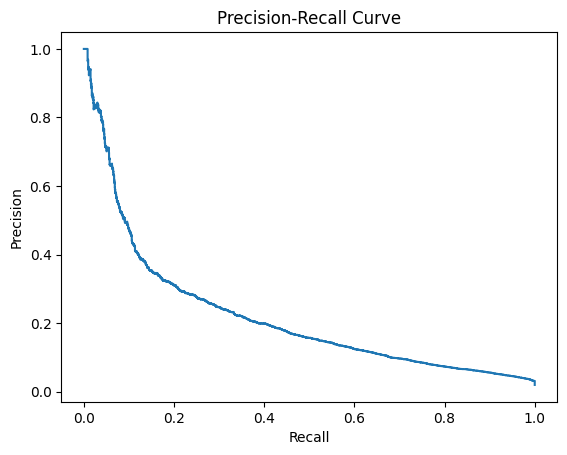

['xgb_7.pkl']

In [112]:
xgb_model = XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_under, y_train_under)

y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba)}")
print("AUC-PR:", average_precision_score(y_test, y_pred_proba))
df_preds = precision_at_k(y_test, y_pred, k_percent=0.05)

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# Save the model
joblib.dump(xgb_model, "xgb_7.pkl")


In [113]:
# weight ratio between the majority class (non-returns) and the minority class (returns) in the training data.
scale_pos_weight_under = (y_train_under == 0).sum() / (y_train_under == 1).sum()
print(f"scale_pos_weight: {scale_pos_weight_under:.2f}")

scale_pos_weight: 3.00


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [00:57:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.99      0.79      0.88    157907
           1       0.07      0.80      0.13      3217

    accuracy                           0.79    161124
   macro avg       0.53      0.80      0.51    161124
weighted avg       0.98      0.79      0.87    161124

AUC-ROC: 0.888298612527582
AUC-PR: 0.22059852138750474
Top-5% Precision: 0.0722


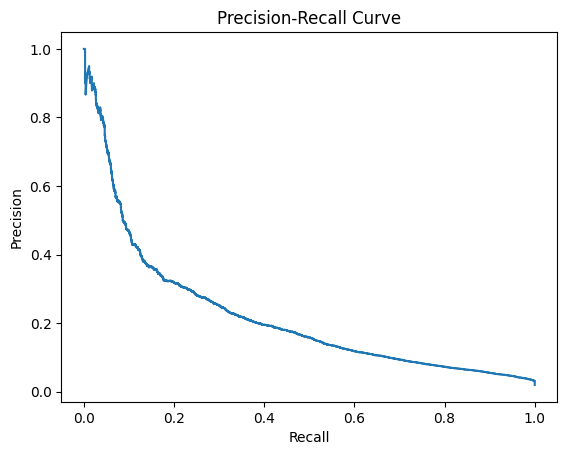

['xgb_8.pkl']

In [114]:
xgb_model = XGBClassifier(
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight_under,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_under, y_train_under)

y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba)}")
print("AUC-PR:", average_precision_score(y_test, y_pred_proba))
df_preds = precision_at_k(y_test, y_pred, k_percent=0.05)

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# Save the model
joblib.dump(xgb_model, "xgb_8.pkl")

              precision    recall  f1-score   support

           0       0.99      0.90      0.94    157907
           1       0.11      0.64      0.19      3217

    accuracy                           0.89    161124
   macro avg       0.55      0.77      0.57    161124
weighted avg       0.97      0.89      0.93    161124

AUC-ROC: 0.8894163954675368
AUC-PR: 0.22593907640868965
Top-5% Precision: 0.1133


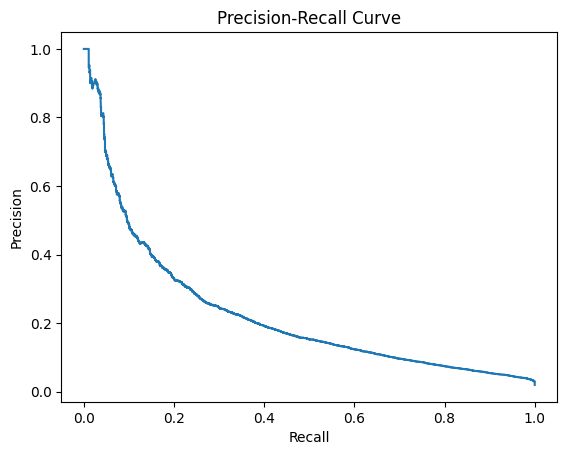

['xgb_9.pkl']

In [115]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_under, y_train_under)

xgb_model = XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_smote, y_train_smote)

y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba)}")
print("AUC-PR:", average_precision_score(y_test, y_pred_proba))
df_preds = precision_at_k(y_test, y_pred, k_percent=0.05)

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

# Save the model
joblib.dump(xgb_model, "xgb_9.pkl")

In [116]:
xgb_model, top_features = load("xgb_5.pkl")
top_features

['CustomerReturnRate',
 'CustomerNumOfReturns',
 'TotalLineValue',
 'Price',
 'CustomerTotalSpend',
 'Quantity',
 'CustomerAvgSpend',
 'InvoiceMonth_cos',
 'CustomerTotalItems',
 'InvoiceMonth_sin',
 'CustomerOrdersPlaced',
 'CustomerLoyaltySpan',
 'CustomerAvgBasketSize',
 'CustomerDaysActive']

In [117]:
X_test_reduced = X_test[top_features]
y_pred = xgb_model.predict(X_test_reduced)
y_pred_proba = xgb_model.predict_proba(X_test_reduced)[:, 1]

print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba)}")
print("AUC-PR:", average_precision_score(y_test, y_pred_proba))
df_preds = precision_at_k(y_test, y_pred, k_percent=0.05)

              precision    recall  f1-score   support

           0       0.99      0.80      0.89    157907
           1       0.07      0.79      0.14      3217

    accuracy                           0.80    161124
   macro avg       0.53      0.80      0.51    161124
weighted avg       0.98      0.80      0.87    161124

AUC-ROC: 0.8874514714524512
AUC-PR: 0.23608489817670353
Top-5% Precision: 0.0740


In [118]:
threshold = 0.4
y_pred_custom = (y_pred_proba > threshold).astype(int)
print(classification_report(y_test, y_pred_custom))
df_preds = precision_at_k(y_test, y_pred_custom, k_percent=0.05)

              precision    recall  f1-score   support

           0       1.00      0.73      0.84    157907
           1       0.06      0.86      0.12      3217

    accuracy                           0.73    161124
   macro avg       0.53      0.80      0.48    161124
weighted avg       0.98      0.73      0.83    161124

Top-5% Precision: 0.0605


Go with Model 5 (ID 7) - 12 features modeled after Model 2.
- Good recall - catching most returns
- Decent precision (0.07) — better than random (baseline is 2%)
- Top-5% precision is stronger (0.0744) than threshold = 0.4
- 12 SHAP features — simpler, faster, more interpretable

#### Tune hyperparameters

In [119]:
xgb_model, top_features = joblib.load("xgb_5.pkl")  # ID 7 model
X_train = X_train[top_features]
X_test = X_test[top_features]

In [120]:
# Define hyperparameter search space
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5, 7]
}

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='recall',
    cv=skf,  # use stratified folds
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Run the search
random_search.fit(X_train, y_train)

# Output best parameters
print("Best parameters found:", random_search.best_params_)
print("Best recall score:", random_search.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [01:00:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [01:00:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [01:00:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [01:00:47] WARNING: /Users/runner/work/xgboost/xgboost/src

Best parameters found: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
Best recall score: 0.8341103341103342


{
    'subsample': 0.8,
    'n_estimators': 200,
    'min_child_weight': 1,
    'max_depth': 3,
    'learning_rate': 0.1,
    'gamma': 0,
    'colsample_bytree': 0.8
}


In [121]:
# Use the best model from RandomizedSearchCV
best_model = random_search.best_estimator_

# Predict with cross-validation
y_pred = cross_val_predict(best_model, X_train, y_train, cv=5)

# Print all metrics
print(classification_report(y_train, y_pred))

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [01:03:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [01:03:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [01:03:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [01:03:04] WARNING: /Users/runner/work/xgboost/xgboost/src

              precision    recall  f1-score   support

           0       1.00      0.76      0.86    631626
           1       0.07      0.83      0.12     12870

    accuracy                           0.76    644496
   macro avg       0.53      0.79      0.49    644496
weighted avg       0.98      0.76      0.85    644496



In [122]:
# Define hyperparameter search space
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5, 7],
    'scale_pos_weight': [30, 40, 50, 60]
}


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_model_10 = XGBClassifier()

random_search = RandomizedSearchCV(
    estimator=xgb_model_10,
    param_distributions=param_dist,
    n_iter=30,
    scoring='recall',
    cv=skf,  # use stratified folds
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Run the search
random_search.fit(X_train, y_train)

# Output best parameters
print("Best parameters found:", random_search.best_params_)
print("Best recall score:", random_search.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found: {'subsample': 0.8, 'scale_pos_weight': 60, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}
Best recall score: 0.8714063714063714


In [123]:
# Use the best model from RandomizedSearchCV
best_model = random_search.best_estimator_

# Predict with cross-validation
y_pred = cross_val_predict(best_model, X_train, y_train, cv=5)

# Print all metrics
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.71      0.83    631626
           1       0.06      0.87      0.11     12870

    accuracy                           0.72    644496
   macro avg       0.53      0.79      0.47    644496
weighted avg       0.98      0.72      0.82    644496



In [124]:
joblib.dump(random_search.best_estimator_, "xgb_10.pkl")

['xgb_10.pkl']

Grid Search = “Brute force” search.
It tries every combination of parameters you give it and finds the one that gives the best performance.

In [ ]:
xgb_model_11 = XGBClassifier(eval_metric="logloss")

param_grid = {
    'max_depth': [3, 4],
    'learning_rate': [0.03, 0.05, 0.07],
    'n_estimators': [250, 300, 350],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.9, 1.0],
    'min_child_weight': [3, 5, 7],
    'gamma': [0, 0.1],
    'scale_pos_weight': [50, 60, 70]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model_11,
    param_grid=param_grid,
    scoring='recall',
    cv=cv,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best GridSearch Params:", grid_search.best_params_)
print("Best Recall:", grid_search.best_score_)

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits
Best GridSearch Params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 250, 'scale_pos_weight': 70, 'subsample': 0.8}
Best Recall: 0.8979797979797979


In [ ]:
best_model = grid_search.best_estimator_

# Predict with cross-validation
y_pred = cross_val_predict(best_model, X_train, y_train, cv=5)

# Print all metrics
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80    631626
           1       0.05      0.90      0.10     12870

    accuracy                           0.67    644496
   macro avg       0.52      0.78      0.45    644496
weighted avg       0.98      0.67      0.79    644496



In [132]:
joblib.dump(grid_search.best_estimator_, "xgb_11.pkl")

['xgb_11.pkl']

Try Optuna for hyperparameter tuning

In [125]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.3),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 30, 70)
    }

    model = XGBClassifier(**params, eval_metric="logloss")
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring=make_scorer(recall_score))
    return scores.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best hyperparameters:", study.best_params)
print("Best recall:", study.best_value)

[I 2025-03-23 01:08:50,062] A new study created in memory with name: no-name-e62af144-934a-40d7-83e8-cc0a69458b69
[I 2025-03-23 01:08:59,751] Trial 0 finished with value: 0.8415695415695416 and parameters: {'n_estimators': 193, 'max_depth': 6, 'learning_rate': 0.015906479349849616, 'subsample': 0.8168508876306939, 'colsample_bytree': 0.8139389325180869, 'gamma': 0.2965825111795862, 'min_child_weight': 1, 'scale_pos_weight': 52}. Best is trial 0 with value: 0.8415695415695416.
[I 2025-03-23 01:09:06,936] Trial 1 finished with value: 0.8873348873348874 and parameters: {'n_estimators': 159, 'max_depth': 5, 'learning_rate': 0.0695715615646783, 'subsample': 0.8246782242360816, 'colsample_bytree': 0.7305513849850723, 'gamma': 0.128227271464744, 'min_child_weight': 5, 'scale_pos_weight': 69}. Best is trial 1 with value: 0.8873348873348874.
[I 2025-03-23 01:09:14,969] Trial 2 finished with value: 0.734965034965035 and parameters: {'n_estimators': 289, 'max_depth': 3, 'learning_rate': 0.0332020

Best hyperparameters: {'n_estimators': 278, 'max_depth': 4, 'learning_rate': 0.010414663135389055, 'subsample': 0.7308492859380656, 'colsample_bytree': 0.6301178022185321, 'gamma': 0.14855528948588556, 'min_child_weight': 2, 'scale_pos_weight': 68}
Best recall: 0.905982905982906


In [126]:
best_params = study.best_params

# Build final model with best params
final_model = XGBClassifier(
    **best_params,
    use_label_encoder=False,
    eval_metric="logloss"
)

# Fit to full training data
final_model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [01:16:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6301178022185321, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.14855528948588556, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.010414663135389055,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=278, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [127]:
print(classification_report(y_train, y_pred))
joblib.dump((final_model, top_features), "xgb_12.pkl")

              precision    recall  f1-score   support

           0       1.00      0.71      0.83    631626
           1       0.06      0.87      0.11     12870

    accuracy                           0.72    644496
   macro avg       0.53      0.79      0.47    644496
weighted avg       0.98      0.72      0.82    644496



['xgb_12.pkl']

In [128]:
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba)}")
print("AUC-PR:", average_precision_score(y_test, y_pred_proba))
df_preds = precision_at_k(y_test, y_pred, k_percent=0.05)

              precision    recall  f1-score   support

           0       1.00      0.65      0.79    157907
           1       0.05      0.91      0.10      3217

    accuracy                           0.66    161124
   macro avg       0.52      0.78      0.44    161124
weighted avg       0.98      0.66      0.78    161124

AUC-ROC: 0.876762145869773
AUC-PR: 0.17155633134792103
Top-5% Precision: 0.0520


In [129]:
final_model = XGBClassifier(**study.best_params, eval_metric="logloss")
final_model.fit(X_train, y_train)
final_model.save_model("return_flagger_xgb_optuna.json")


Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.65      0.79    157907
           1       0.05      0.91      0.10      3217

    accuracy                           0.66    161124
   macro avg       0.52      0.78      0.44    161124
weighted avg       0.98      0.66      0.78    161124

Confusion Matrix:
 [[103281  54626]
 [   300   2917]]


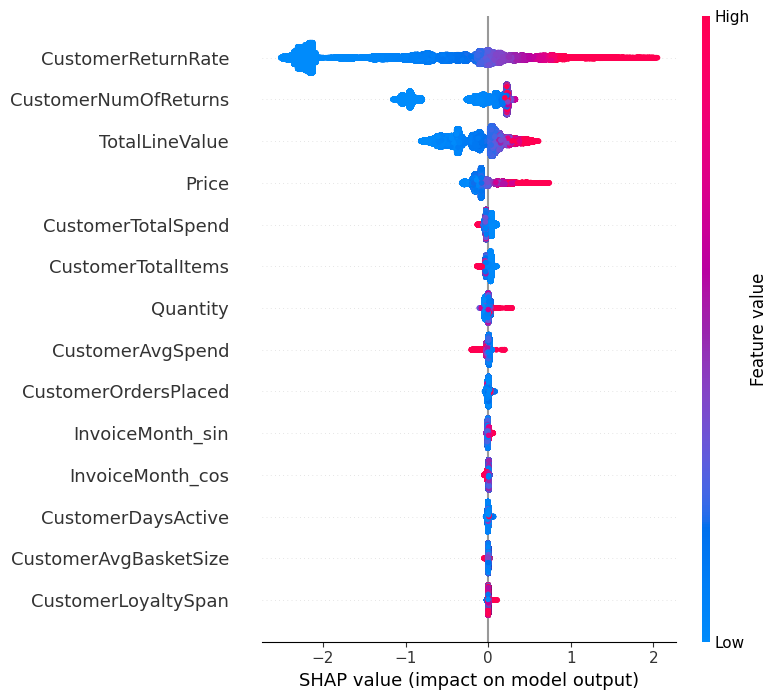

In [130]:
# Evaluate on training set (or use a holdout test set if available)
y_pred = final_model.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# SHAP explanations (optional but great for interpretability)
explainer = shap.Explainer(final_model)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

# Save important features
feature_importance = pd.Series(final_model.feature_importances_, index=X_test.columns)
feature_importance.sort_values(ascending=False).to_csv("feature_importance.csv")

In [131]:
# Save X (features)
X_train.to_csv("X_train_selected.csv", index=False)
X_test.to_csv("X_test_selected.csv", index=False)

# Save y (target)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

#### Benchmark with logistic regression.

In [132]:
X_train.head()

,CustomerReturnRate,CustomerNumOfReturns,TotalLineValue,Price,CustomerTotalSpend,Quantity,CustomerAvgSpend,InvoiceMonth_cos,CustomerTotalItems,InvoiceMonth_sin,CustomerOrdersPlaced,CustomerLoyaltySpan,CustomerAvgBasketSize,CustomerDaysActive
116868,0.000000,0,6.30,2.10,2093.06,3,190.278182,-0.500000,1308,8.660254e-01,11,725,118.909091,10
220051,0.036082,7,17.70,2.95,3213.72,6,214.248000,-0.866025,1662,-5.000000e-01,15,689,110.800000,15
296179,0.000000,0,15.00,1.25,1550.63,12,310.126000,0.500000,1550,-8.660254e-01,5,217,310.000000,5
394375,0.001664,3,2.95,2.95,24516.46,1,454.008519,1.000000,12666,-2.449294e-16,54,729,234.555556,51
787578,0.000000,0,2.55,0.85,303.09,3,75.772500,0.866025,263,-5.000000e-01,4,0,65.750000,2


In [134]:
from sklearn.preprocessing import StandardScaler

# Features to exclude from scaling
exclude = ['InvoiceMonth_sin', 'InvoiceMonth_cos']
features_to_scale = [col for col in X_train.columns if col not in exclude]

X_train_features_to_scale = X_train[features_to_scale]
X_test_features_to_scale = X_test[features_to_scale]

# Fit scaler on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features_to_scale)

# Apply same scaler to test data
X_test_scaled = scaler.transform(X_test_features_to_scale)

# Convert scaled features back to DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=features_to_scale, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features_to_scale, index=X_test.index)

# Keep the excluded columns as-is
X_train_excluded = X_train[exclude]
X_test_excluded = X_test[exclude]

# Recombine scaled and excluded features
X_train_final = pd.concat([X_train_scaled_df, X_train_excluded], axis=1)
X_test_final = pd.concat([X_test_scaled_df, X_test_excluded], axis=1)

In [137]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression with balanced class weight for fairness
log_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_model.fit(X_train_final, y_train)

# Predict using cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_log = cross_val_predict(log_model, X_test_final, y_test, cv=cv)
y_proba_log = cross_val_predict(log_model, X_test_final, y_test, cv=cv, method='predict_proba')[:, 1]

# Evaluation
print("🔍 Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log))

# AUC-ROC
roc_auc_log = roc_auc_score(y_test, y_proba_log)
print("AUC-ROC:", roc_auc_log)

# AUC-PR
print("AUC-PR:", average_precision_score(y_test, y_pred_log))

🔍 Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91    157907
           1       0.08      0.67      0.14      3217

    accuracy                           0.84    161124
   macro avg       0.54      0.76      0.53    161124
weighted avg       0.97      0.84      0.90    161124

AUC-ROC: 0.8587724153133982
AUC-PR: 0.06072749364659636


In [138]:
print(log_model.coef_) 

[[ 1.26232941  0.1093588   0.51850304  2.30774765 -0.25132816 -0.02726357
   0.01646424  0.10999937  0.0513071   0.19788034 -0.0276608   0.02972442
   0.06704036 -0.13142447]]


In [139]:
X_train_final.columns

Index(['CustomerReturnRate', 'CustomerNumOfReturns', 'TotalLineValue', 'Price',
       'CustomerTotalSpend', 'Quantity', 'CustomerAvgSpend',
       'CustomerTotalItems', 'CustomerOrdersPlaced', 'CustomerLoyaltySpan',
       'CustomerAvgBasketSize', 'CustomerDaysActive', 'InvoiceMonth_sin',
       'InvoiceMonth_cos'],
      dtype='object')

In [141]:
from sklearn.linear_model import LogisticRegressionCV

log_cv = LogisticRegressionCV(
    Cs=10,  # Try 10 values from small to large
    cv=5,
    scoring='recall',  # You can also try 'f1' or 'average_precision'
    class_weight='balanced',
    penalty='l2',  # Ridge regularization
    solver='liblinear',
    max_iter=1000,
    random_state=42
)
log_cv.fit(X_train_final, y_train)

# Predict using cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_log = cross_val_predict(log_cv, X_test_final, y_test, cv=cv)
y_proba_log = cross_val_predict(log_cv, X_test_final, y_test, cv=cv, method='predict_proba')[:, 1]

# Evaluation
print("🔍 Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log))

# AUC-ROC
roc_auc_log = roc_auc_score(y_test, y_proba_log)
print("AUC-ROC:", roc_auc_log)

# AUC-PR
print("AUC-PR:", average_precision_score(y_test, y_pred_log))

🔍 Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90    157907
           1       0.07      0.67      0.13      3217

    accuracy                           0.82    161124
   macro avg       0.53      0.75      0.52    161124
weighted avg       0.97      0.82      0.89    161124

AUC-ROC: 0.8481487361190765
AUC-PR: 0.05548440550413488
